# Отчёт по домашнему заданию №2

### Студент: Крамин Мурат Тимурович

## Задание 2: Построение простого классификатора изображений и анализ изображений

### Цель
Узнать, как применять методы машинного обучения для классификации изображений и сравнивать эффективность классических алгоритмов и нейронных сетей.

---

#### 1. Подготовка данных

### Задание:
- Выберите набор данных:
  - MNIST для классификации рукописных цифр.
  - CIFAR-10 для классификации объектов на цветных изображениях.
- Разделите данные на обучающий (80%) и тестовый (20%) наборы.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,roc_auc_score

import time


In [ ]:
# Трансформации: приводим данные к тензорам и нормируем их
transform = transforms.Compose([
    transforms.ToTensor(),
    # Нормировка по среднему и СКО CIFAR-10 (стандартные значения, эмпирические)
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

# Загружаем CIFAR-10 (50k train + 10k test)
cifar_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Берем только 12 000 примеров
subset_size = 12_000
cifar_subset, _ = random_split(cifar_full, [subset_size, len(cifar_full) - subset_size])

# Разделим на 80/20
train_size = int(0.8 * subset_size)
test_size = subset_size - train_size
train_dataset, test_dataset = random_split(cifar_subset, [train_size, test_size])

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")


Train size: 8000, Test size: 2000


In [ ]:
from collections import Counter
import pandas as pd

# Считаем распределение по классам
y_all = [label for _, label in cifar_subset]
class_counts = Counter(y_all)

# Преобразуем в DataFrame для удобства и анализа
class_dist_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
class_dist_df.index.name = 'class'
class_dist_df.reset_index(inplace=True)

# Добавим процентное распределение
total_samples = class_dist_df['count'].sum()
class_dist_df['percent'] = class_dist_df['count'] / total_samples * 100
class_dist_df.sort_values(by='count', ascending=False, inplace=True)


print("Распределение классов в датасете:\n")
for _, row in class_dist_df.iterrows():
    print(f"  - Класс {row['class']}: {row['count']} изображений ({row['percent']:.2f}%)")

Распределение классов в полном датасете:

  - Класс 8.0: 1054.0 изображений (10.54%)
  - Класс 5.0: 1013.0 изображений (10.13%)
  - Класс 6.0: 1007.0 изображений (10.07%)
  - Класс 1.0: 1006.0 изображений (10.06%)
  - Класс 3.0: 1003.0 изображений (10.03%)
  - Класс 7.0: 1002.0 изображений (10.02%)
  - Класс 9.0: 991.0 изображений (9.91%)
  - Класс 4.0: 980.0 изображений (9.80%)
  - Класс 2.0: 976.0 изображений (9.76%)
  - Класс 0.0: 968.0 изображений (9.68%)


In [ ]:
# Функция преобразует PyTorch dataset в NumPy массивы признаков и меток
def dataset_to_arrays(dset, max_samples=5000):
    X_list, y_list = [], []
    for i, (img, label) in enumerate(dset):
        # превращаем вектор размерности [3, 32, 32] => [3072]
        X_list.append(img.view(-1).numpy())
        y_list.append(label)
        if i >= max_samples - 1:
            break
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

X_train_small, y_train_small = dataset_to_arrays(train_dataset, max_samples=10000)
X_test_small, y_test_small = dataset_to_arrays(test_dataset, max_samples=2000)

print("Форма X_train_small:", X_train_small.shape)
print("Форма X_test_small:", X_test_small.shape)


In [ ]:
from sklearn.dummy import DummyClassifier

# Создаём случайный классификатор (uniform: случайный выбор класса)
random_clf = DummyClassifier(strategy='uniform', random_state=42)

start_time = time.time()
random_clf.fit(X_train_small, y_train_small)
train_time_random = time.time() - start_time

y_pred_random = random_clf.predict(X_test_small)
y_prob_random = random_clf.predict_proba(X_test_small)

# Метрики
acc_random = accuracy_score(y_test_small, y_pred_random)
recall_random = recall_score(y_test_small, y_pred_random, average='macro')
precision_random = precision_score(y_test_small, y_pred_random, average='macro')
f1_random = f1_score(y_test_small, y_pred_random, average='macro')
roc_auc_random = roc_auc_score(y_test_small, y_prob_random, multi_class='ovr', average='macro')

print("=== Случайный классификатор ===")
print("Training time: {:.3f} seconds".format(train_time_random))
print("Accuracy:", acc_random)
print("Recall (macro):", recall_random)
print("Precision (macro):", precision_random)
print("F1-score (macro):", f1_random)
print("ROC-AUC (macro, OVR):", roc_auc_random)
print("\nКлассификационный отчёт:\n", classification_report(y_test_small, y_pred_random))


=== Случайный классификатор (baseline) ===
Training time: 0.008 seconds
Accuracy: 0.097
Recall (macro): 0.09731305851330685
Precision (macro): 0.09625569628732915
F1-score (macro): 0.0966788017896322
ROC-AUC (macro, OVR): 0.5

Классификационный отчёт:
               precision    recall  f1-score   support

           0       0.15      0.16      0.15       210
           1       0.09      0.09      0.09       192
           2       0.11      0.12      0.12       194
           3       0.07      0.06      0.07       214
           4       0.09      0.09      0.09       205
           5       0.09      0.09      0.09       194
           6       0.11      0.10      0.11       205
           7       0.14      0.15      0.14       186
           8       0.07      0.06      0.07       201
           9       0.05      0.06      0.05       199

    accuracy                           0.10      2000
   macro avg       0.10      0.10      0.10      2000
weighted avg       0.10      0.10      0.10

### Выводы по подготовке данных

- Для алгоритмов kNN и SVM тренировать их на всех 50k образцах на обычном ноутбуке оказалось слишком долго. Поэтому была выбрана поменьше выборка 10k для иллюстрации подходов.

- В сделанной подвыборке было исследовано распределение классов и выявлено что классы сбалансированы

- Для классических алгоритмов kNN и SVM нам нужны numpy-массивы а не тензоры, что и было проделано выше

- Также был написан случайный классификатор для последующего сравнения с ним моделей


## 2. Классификация с помощью kNN/SVM

### Задание:
- Реализуйте классификатор k-Nearest Neighbors (kNN) или машину опорных  
векторов (SVM).
- Обучите модель на обучающем наборе.
- Прогнозирование классов на тестовом множестве.
- Рассчитайте метрики оценки: accuracy, recall, F1-score. 
- Постройте сonfusion matrix.

#### 2.1 kNN

In [ ]:
# Выбираем количество соседей для kNN
k = 5 
# Инициализируем классификатор k-ближайших соседей (kNN) с параллельной обработкой
# n_jobs=-1 позволяет использовать все ядра CPU для ускорения обучения
knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

start_time = time.time()
# Обучение на уменьшенной обучающей выборке
knn.fit(X_train_small, y_train_small)
train_time_knn = time.time() - start_time

# Предсказания классов на тестовой выборке
y_pred_knn = knn.predict(X_test_small)
y_prob_knn = knn.predict_proba(X_test_small)  # для ROC-AUC

# Вычисляем метрики качества
acc_knn = accuracy_score(y_test_small, y_pred_knn)
recall_knn = recall_score(y_test_small, y_pred_knn, average='macro')
f1_knn = f1_score(y_test_small, y_pred_knn, average='macro')
precision_knn = precision_score(y_test_small, y_pred_knn, average='macro')

# ROC-AUC для мультиклассового случая (One-vs-Rest, macro-average)
roc_auc_knn = roc_auc_score(y_test_small, y_prob_knn, multi_class='ovr', average='macro')

# Вывод результатов
print("=== kNN ===")
print("Training time: {:.3f} seconds".format(train_time_knn))
print("Accuracy:", acc_knn)
print("Recall (macro):", recall_knn)
print("Precision (macro):", precision_knn)
print("F1-score (macro):", f1_knn)
print("ROC-AUC (macro, OVR):", roc_auc_knn)
print("\nКлассификационный отчёт:\n", classification_report(y_test_small, y_pred_knn))


=== kNN ===
Training time: 0.033 seconds
Accuracy: 0.286
Recall (macro): 0.2832719400656916
Precision (macro): 0.3540560171704729
F1-score (macro): 0.2619105442352908
ROC-AUC (macro, OVR): 0.6890659678089108

Классификационный отчёт:
               precision    recall  f1-score   support

           0       0.35      0.50      0.41       210
           1       0.44      0.08      0.13       192
           2       0.21      0.44      0.28       194
           3       0.27      0.17      0.21       214
           4       0.20      0.40      0.26       205
           5       0.32      0.15      0.21       194
           6       0.26      0.25      0.25       205
           7       0.51      0.10      0.16       186
           8       0.36      0.60      0.45       201
           9       0.62      0.16      0.25       199

    accuracy                           0.29      2000
   macro avg       0.35      0.28      0.26      2000
weighted avg       0.35      0.29      0.26      2000



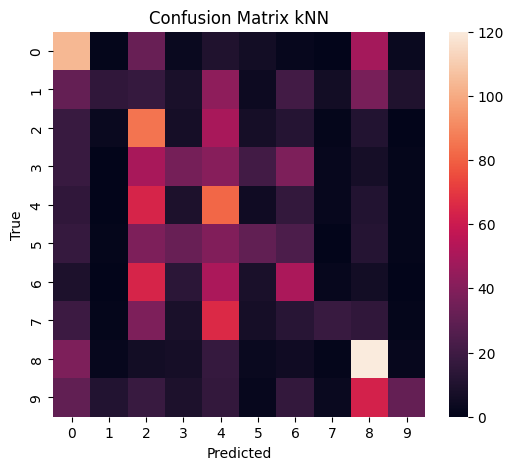

In [ ]:
# Строим confusion matrix для kNN
cm_knn = confusion_matrix(y_test_small, y_pred_knn)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=False, fmt='d')
plt.title('Confusion Matrix kNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Выводы по модели kNN:

Модель kNN показала относительно низкую точность:

- Accuracy составила всего 28.6%, что не сильно выше случайной классификации при 10 классах (~10% у случайного классификатора).
- Recall и F1-score (macro) также низкие: 0.28 и 0.26 соответственно, что говорит о слабом распознавании объектов по всем классам.
- ROC-AUC (macro, OVR) = 0.69 - выше случайного (0.5), но всё ещё недостаточен для практического применения.

Из классификационного отчёта видно:
- Лучше всего модель справляется с классами 0 (автомобиль) и 8 (корабль) - F1 около 0.4–0.45.
- Хуже всего - с классами 1 (грузовик) и 7 (лошадь), где recall не превышает 0.1.

Confusion Matrix показывает, что:
- Модель часто путает визуально похожие классы (например, 1 и 4, 3 и 5, 6 и 2).
- Для большинства классов предсказания сильно размыты и не сосредоточены вдоль диагонали.

Возможные причины слабых результатов kNN:
- Высокая размерность данных затруднительна для kNN.
- Классы сильно перекрываются в пространстве признаков, что мешает ближайшим соседям работать корректно.

#### 2.2 SVM

In [ ]:
# Закомментировано для ускорения: GridSearch подбирает лучшие гиперпараметры но очень долго

# param_grid = {
#     'C': [1],
#     #'C': [0.1, 1, 10],
#     #'gamma': ['scale', 0.01, 0.001],
#     'gamma': ['scale'],
#     'kernel': ['linear']
# }

# # Включаем probability=True для roc_auc_score
# svm_base = SVC(probability=True)
# grid_search = GridSearchCV(svm_base, param_grid, cv=3, verbose=2, n_jobs=-1)

# # Используем всё те же X_train_small, y_train_small
# start_time = time.time()
# grid_search.fit(X_train_small, y_train_small)
# train_time_svm = time.time() - start_time

# print("Лучшие параметры:", grid_search.best_params_)
# svm_clf = grid_search.best_estimator_

start_time = time.time()
# Инициализируем SVM-классификатор с RBF-ядром и возможностью предсказывать вероятности
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale',probability=True)

svm_clf.fit(X_train_small, y_train_small)
# Предсказываем вероятности принадлежности к классам (нужно для ROC-AUC)
train_time_svm = time.time() - start_time

# Предсказываем метки классов на тестовой выборке
y_pred_svm = svm_clf.predict(X_test_small)
y_prob_svm = svm_clf.predict_proba(X_test_small)

# Вычисляем метрики качества
acc_svm = accuracy_score(y_test_small, y_pred_svm)
recall_svm = recall_score(y_test_small, y_pred_svm, average='macro')
precision_svm = precision_score(y_test_small, y_pred_svm, average='macro')
f1_svm = f1_score(y_test_small, y_pred_svm, average='macro')
roc_auc_svm = roc_auc_score(y_test_small, y_prob_svm, multi_class='ovr', average='macro')

# Вывод результатов
print("=== SVM ===")
print("Training time: {:.3f} seconds".format(train_time_svm))
print("Accuracy:", acc_svm)
print("Recall (macro):", recall_svm)
print("Precision (macro):", precision_svm)
print("F1-score (macro):", f1_svm)
print("ROC-AUC (macro, OVR):", roc_auc_svm)
print("\nКлассификационный отчёт:\n", classification_report(y_test_small, y_pred_svm))


=== SVM ===
Training time: 787.866 seconds
Accuracy: 0.4395
Recall (macro): 0.44019544307657404
Precision (macro): 0.4358065753127652
F1-score (macro): 0.4361413793728068
ROC-AUC (macro, OVR): 0.855873759044066

Классификационный отчёт:
               precision    recall  f1-score   support

           0       0.54      0.47      0.50       210
           1       0.45      0.43      0.44       192
           2       0.33      0.32      0.33       194
           3       0.35      0.28      0.31       214
           4       0.37      0.33      0.35       205
           5       0.35      0.37      0.36       194
           6       0.47      0.58      0.52       205
           7       0.51      0.51      0.51       186
           8       0.54      0.60      0.57       201
           9       0.45      0.52      0.48       199

    accuracy                           0.44      2000
   macro avg       0.44      0.44      0.44      2000
weighted avg       0.44      0.44      0.44      2000



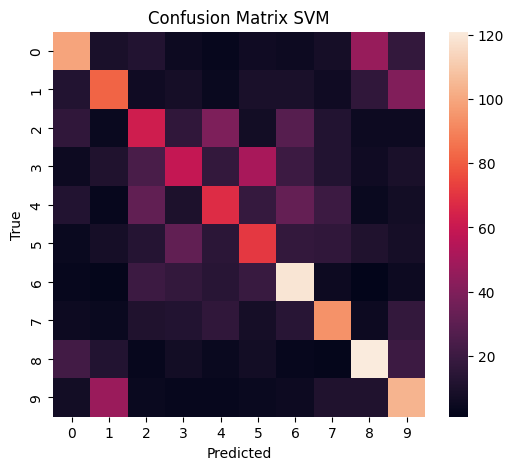

In [ ]:
# Строим confusion matrix для kNN
cm_svm = confusion_matrix(y_test_small, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=False, fmt='d')
plt.title('Confusion Matrix SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Выводы по модели SVM

Модель SVM с ядром RBF показала заметно лучшую производительность, чем kNN, но при этом требует значительно больше времени на обучение:

- Accuracy = 43.95%, что почти в 1.5 раза выше, чем у kNN.
- Метрики Recall, Precision и F1-score находятся в районе 0.44, что свидетельствует об умеренной способности модели обобщать по всем классам.
- ROC-AUC = 0.86 также это довольно хороший результат, показывающий, что SVM может неплохо ранжировать классы, несмотря на невысокую точность.

#### Классификационный отчёт:
- Наилучшие результаты по F1-score показали классы:
  - 8 (корабль) - F1 ~ 0.57
  - 6 (лягушка) - F1 ~ 0.52
  - 0 (самолёт) и 9 (грузовик) - F1 ~ 0.48–0.50
- Хуже всего модель справляется с классами:
  - 3 (кошка), 2 (птица) и 4 (олень) - F1 ~ 0.31–0.35

#### Confusion Matrix:
- В отличие от kNN, диагональные элементы матрицы заметно ярче выражены - модель реже путает классы, но ошибки всё ещё часто случаются между похожими визуально объектами, например, классы 3 и 5, 1 и 9.
- Особенно сильно путаются животные (кошка, собака, олень), что ожидаемо, потому как они сложны для линейного разделения в пиксельном пространстве.

#### Преимущества:
- Лучшая обобщающая способность по сравнению с kNN на том же датасете.
- Высокое значение ROC-AUC означает, что модель потенциально пригодна для задач ранжирования или как часть ансамбля.

#### Недостатки:
- Очень высокое время обучения - почти 800 секунд даже на небольшой выборке.
- Параметры (ядро, C, gamma) требуют подбора, что усложняет использование модели.

## 3. Построение и обучение нейронной сети

### Задание:
- Создайте многослойный перцептрон (MLP) с помощью Keras или PyTorch.
- Определите архитектуру сети (количество слоев, нейронов, функций  
активации).
- Обучите модель на том же наборе данных.
- Проанализируйте динамику обучения (графики потерь и точности).

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=3072, hidden1=512, hidden2=256, output_dim=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1) # первый скрытый слой
        self.fc2 = nn.Linear(hidden1, hidden2) # второй скрытый слой
        self.fc3 = nn.Linear(hidden2, output_dim) # выходной слой (число классов)
        
    def forward(self, x):
        # x имеет форму [batch_size, 3, 32, 32] — изображения
        # Преобразуем изображения в плоские векторы: [batch_size, 3072]
        x = x.view(x.size(0), -1)
        # Применяем ReLU-активации после каждого скрытого слоя
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Последний слой — без активации, выдаёт логиты для softmax/кросс-энтропии
        x = self.fc3(x) 
        return x


In [ ]:
batch_size = 128 # Размер мини-батча
# DataLoader для обучающей выборки
# shuffle=True — случайное перемешивание примеров перед каждой эпохой
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# DataLoader для тестовой выборки
# shuffle=False — порядок данных сохраняется
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

model = MLP().to(device)
# Функция потерь — кросс-энтропия, подходящая для многоклассовой классификации
criterion = nn.CrossEntropyLoss()
# Оптимизатор — Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

# Для отслеживания динамики обучения
train_losses = []
train_accuracies = []
test_accuracies = []

start_time = time.time()  # Старт замера

# Цикл по эпохам
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Цикл по мини-батчам обучающей выборки
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() # Обнуляем градиенты
        outputs = model(images) # Прямой проход
        loss = criterion(outputs, labels) # Вычисляем значение функции потерь
        loss.backward() # Обратное распространение ошибки
        optimizer.step() # Обновление весов
        
        running_loss += loss.item() * images.size(0) # Суммируем потери по батчам
        
        # Предсказания меток и подсчёт правильно угаданных
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # Оценка на тесте (для контроля динамики обучения)
    model.eval() # Переводим модель в режим оценки
    correct_test = 0
    total_test = 0
    
    # Без подсчёта градиентов
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
            
    test_acc = correct_test / total_test
    test_accuracies.append(test_acc)
    # Вывод статистики по эпохе
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {epoch_loss:.4f}  "
          f"Train Acc: {epoch_acc:.4f}  Test Acc: {test_acc:.4f}")
train_time_mlp = time.time() - start_time # Засекаем общее время обучения



Device: cpu
Epoch [1/10]  Loss: 1.8620  Train Acc: 0.3359  Test Acc: 0.3825
Epoch [2/10]  Loss: 1.5853  Train Acc: 0.4348  Test Acc: 0.3840
Epoch [3/10]  Loss: 1.4304  Train Acc: 0.5018  Test Acc: 0.4070
Epoch [4/10]  Loss: 1.2768  Train Acc: 0.5495  Test Acc: 0.3880
Epoch [5/10]  Loss: 1.1562  Train Acc: 0.5976  Test Acc: 0.4160
Epoch [6/10]  Loss: 1.0174  Train Acc: 0.6416  Test Acc: 0.4000
Epoch [7/10]  Loss: 0.8667  Train Acc: 0.7027  Test Acc: 0.4135
Epoch [8/10]  Loss: 0.7520  Train Acc: 0.7430  Test Acc: 0.4095
Epoch [9/10]  Loss: 0.6108  Train Acc: 0.7956  Test Acc: 0.4310
Epoch [10/10]  Loss: 0.5039  Train Acc: 0.8297  Test Acc: 0.4065


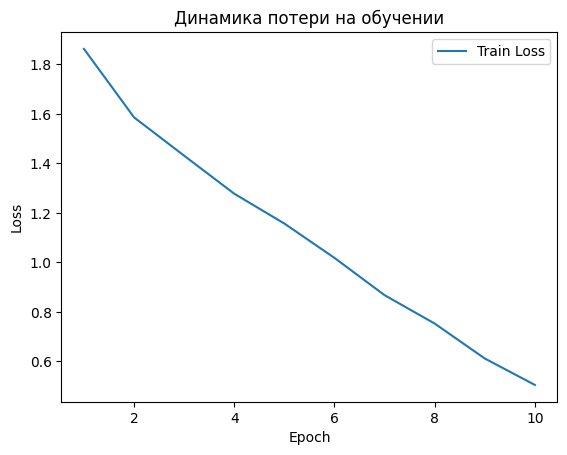

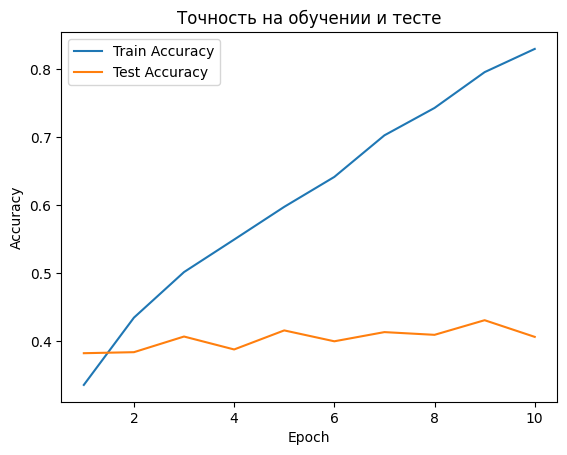

In [ ]:
# Строим графики динамики обучения
epochs_range = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.title("Динамика потери на обучении")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.title("Точность на обучении и тесте")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


=== MLP ===
Total MLP training time: 23.605 seconds
Accuracy: 0.4065
Recall (macro): 0.4076128240613963
Precision (macro): 0.410181385584511
F1-score (macro): 0.40454290314527536
ROC-AUC (macro, OVR): 0.8266627366533962

Классификационный отчёт:
               precision    recall  f1-score   support

           0       0.46      0.52      0.49       210
           1       0.42      0.51      0.46       192
           2       0.38      0.25      0.30       194
           3       0.34      0.31      0.33       214
           4       0.28      0.26      0.27       205
           5       0.32      0.36      0.34       194
           6       0.39      0.45      0.42       205
           7       0.45      0.55      0.49       186
           8       0.59      0.41      0.49       201
           9       0.49      0.45      0.47       199

    accuracy                           0.41      2000
   macro avg       0.41      0.41      0.40      2000
weighted avg       0.41      0.41      0.40      

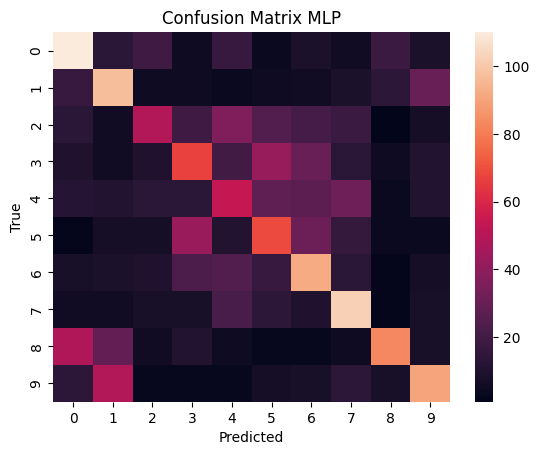

In [ ]:
model.eval() # Переводим модель в режим оценки

# Инициализируем списки для меток, предсказаний и вероятностей
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        # Получаем выходы модели (логиты)
        outputs = model(images)

        # Предсказания классов
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Применяем softmax для перевода логитов в вероятности
        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

# Вычисление метрик на основе всех собранных предсказаний и меток
acc_mlp = accuracy_score(all_labels, all_preds)
recall_mlp = recall_score(all_labels, all_preds, average='macro')
precision_mlp = precision_score(all_labels, all_preds, average='macro')
f1_mlp = f1_score(all_labels, all_preds, average='macro')
roc_auc_mlp = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
cm_mlp = confusion_matrix(all_labels, all_preds)


# Вывод результатов
print("=== MLP ===")
print(f"Total MLP training time: {train_time_mlp:.3f} seconds")
print("Accuracy:", acc_mlp)
print("Recall (macro):", recall_mlp)
print("Precision (macro):", precision_mlp)
print("F1-score (macro):", f1_mlp)
print("ROC-AUC (macro, OVR):", roc_auc_mlp)
print("\nКлассификационный отчёт:\n", classification_report(all_labels, all_preds))

# Визуализация матрицы
plt.figure()
sns.heatmap(cm_mlp, annot=False, fmt='d')
plt.title("Confusion Matrix MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Выводы по модели MLP

MLP с не очень сложной архитектурой показала результаты, сопоставимые с SVM, но с меньшими затратами времени:

- Accuracy = 40.65%, что чуть ниже результата SVM (43.95%), но выше, чем у kNN (28.6%).
- F1-score и Recall ~ 0.40 - средние значения, указывающие на сбалансированную, но не идеальную работу модели по всем классам.
- ROC-AUC = 0.827 - хороший показатель, означающий, что модель умеет различать классы, несмотря на невысокую точность.

#### Динамика обучения:
- С каждой эпохой точность на обучении росла от 33% до 83%, что говорит о хорошей способности модели к обучению.
- Однако тестовая точность стабилизировалась в районе 40–43% и даже начала снижаться к последним эпохам, поэтому явно указывакт на сильное переобучение модели.
- Потери уверенно убывали, но обобщающая способность модели почти не росла после 5–6 эпох.

#### Классификационный отчёт:
- Лучше всего модель распознавала классы:
  - 0 (самолёт), 1 (автомобиль), 7 (лошадь), 8 (корабль), 9 (грузовик) - F1-score от 0.46 до 0.49.
- Сложности наблюдаются на классах:
  - 2 (птица), 3 (кошка), 4 (олень) - F1 ниже 0.35.

#### Confusion Matrix:
- Матрица ошибок показывает достаточно чёткую диагональ, но есть существенные пересечения между схожими классами (особенно у животных).
- Ошибки часто происходят между 3 (кошка) и 5 (собака), а также между 2 (птица) и 4 (олень).

#### Преимущества:
- Модель обучается значительно быстрее, чем SVM (23 секунды против 788 секунд).
- Не требует ручного подбора ядра или гиперпараметров.

#### Недостатки:
- Простая архитектура MLP не учитывает структуру изображений, в отличие от CNN.
- Быстро впадает в переобучение, так как параметры растут, а модель слишком мощная для небольшой выборки.


#### MLP с dropout и с scheduler

Теперь я добавлю Dropout в архитектуру MLP и Scheduler в процесс обучения для того, чтобы:

- Dropout помог избежать переобучения, случайно отключая часть нейронов во время обучения и тем самым повышая обобщающую способность модели.
- Scheduler постепенно снижал скорость обучения, чтобы модель сначала обучалась быстрее, а затем точнее настраивала веса, улучшая сходимость и итоговую точность.

In [ ]:
class MLP_upgraded(nn.Module):
    def __init__(self, input_dim=3*32*32, hidden1=512, hidden2=256, output_dim=10, dropout_rate=0.5):
        super(MLP_upgraded, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1) # Первый скрытый слой
        self.fc2 = nn.Linear(hidden1, hidden2) # Второй скрытый слой
        self.fc3 = nn.Linear(hidden2, output_dim) # Выходной слой (логиты)
        self.dropout = nn.Dropout(dropout_rate) # Dropout для регуляризации (с вероятностью отключения dropout_rate)

        
    def forward(self, x):
        # x: [batch_size, 3, 32, 32]
        x = x.view(x.size(0), -1) # Преобразуем в [batch_size, 3072]
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # применяем dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x) # применяем dropout
        x = self.fc3(x) # логиты
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

model = MLP_upgraded(dropout_rate=0.5).to(device)  # dropout_rate можно настраивать

# Функция потерь — кросс-энтропия
criterion = nn.CrossEntropyLoss()
# Оптимизатор Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Планировщик (scheduler) уменьшает скорость обучения в 2 раза каждые 5 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 10

# Списки для хранения истории обучения
train_losses = []
train_accuracies = []
test_accuracies = []

start_time = time.time()  # Старт замера

# Основной цикл обучения по эпохам
for epoch in range(num_epochs):
    model.train() # Режим обучения (включает dropout)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() # Обнуляем градиенты
        outputs = model(images) # Прямой проход
        loss = criterion(outputs, labels) # Вычисляем ошибку
        loss.backward() # Обратное распространение ошибки
        optimizer.step() # Обновляем веса
        
        # Агрегируем потери и точность
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # Шаг планировщика после каждой эпохи
    scheduler.step()
    
    # Средние значения метрик за эпоху
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # Оценка модели на тестовой выборке
    model.eval()
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
            
    test_acc = correct_test / total_test
    test_accuracies.append(test_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {epoch_loss:.4f}  "
          f"Train Acc: {epoch_acc:.4f}  Test Acc: {test_acc:.4f}")
    
train_time_mlp_upgraded = time.time() - start_time  # Время обучения всей модели



Device: cpu
Epoch [1/10]  Loss: 2.0893  Train Acc: 0.2615  Test Acc: 0.3560
Epoch [2/10]  Loss: 1.8680  Train Acc: 0.3430  Test Acc: 0.3640
Epoch [3/10]  Loss: 1.8225  Train Acc: 0.3536  Test Acc: 0.3805
Epoch [4/10]  Loss: 1.7638  Train Acc: 0.3711  Test Acc: 0.3965
Epoch [5/10]  Loss: 1.7161  Train Acc: 0.3951  Test Acc: 0.3900
Epoch [6/10]  Loss: 1.6400  Train Acc: 0.4183  Test Acc: 0.4055
Epoch [7/10]  Loss: 1.5839  Train Acc: 0.4325  Test Acc: 0.4205
Epoch [8/10]  Loss: 1.5472  Train Acc: 0.4462  Test Acc: 0.4250
Epoch [9/10]  Loss: 1.5300  Train Acc: 0.4511  Test Acc: 0.4255
Epoch [10/10]  Loss: 1.4990  Train Acc: 0.4616  Test Acc: 0.4300


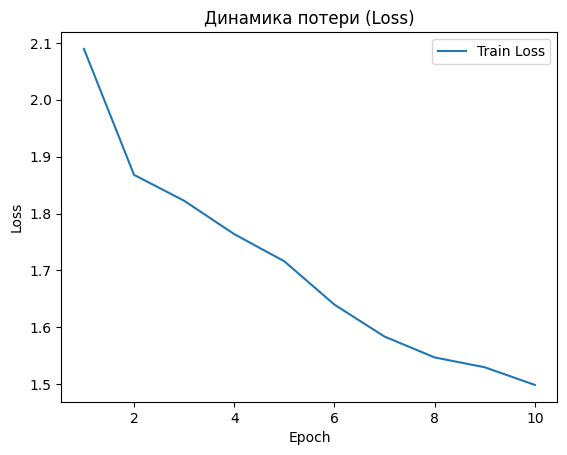

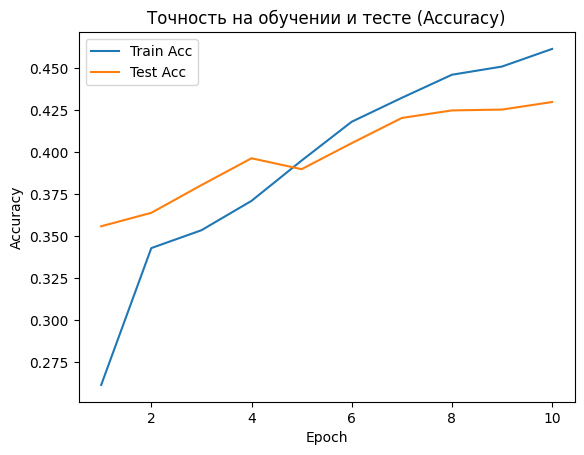

In [ ]:
# Строим графики динамики обучения
epochs_range = range(1, num_epochs+1)

plt.figure()
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.title("Динамика потери (Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, train_accuracies, label='Train Acc')
plt.plot(epochs_range, test_accuracies, label='Test Acc')
plt.title("Точность на обучении и тесте (Accuracy)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


=== MLP (с Dropout, Scheduler) ===
Total MLP training time: 23.445 seconds
Accuracy: 0.43
Recall (macro): 0.43152945729824577
Precision (macro): 0.4284315601090044
F1-score (macro): 0.42759856472657953
ROC-AUC (macro, OVR): 0.842967417056667

Классификационный отчёт:
               precision    recall  f1-score   support

           0       0.51      0.47      0.49       210
           1       0.52      0.49      0.50       192
           2       0.37      0.28      0.32       194
           3       0.30      0.25      0.28       214
           4       0.37      0.32      0.34       205
           5       0.32      0.39      0.35       194
           6       0.45      0.46      0.46       205
           7       0.51      0.53      0.52       186
           8       0.53      0.60      0.56       201
           9       0.42      0.53      0.47       199

    accuracy                           0.43      2000
   macro avg       0.43      0.43      0.43      2000
weighted avg       0.43    

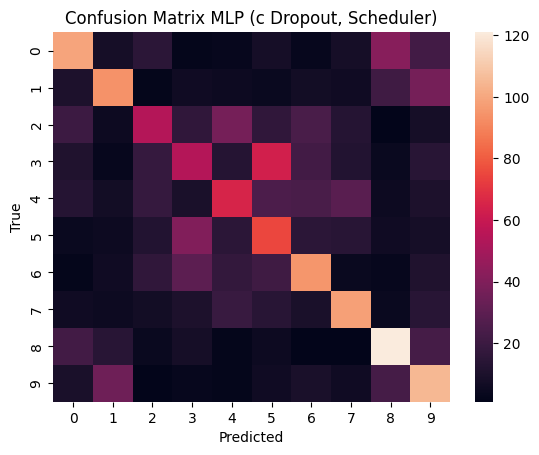

In [ ]:
model.eval() # Переводим модель в режим оценки (выключает dropout)
# Списки для хранения всех предсказаний, меток и вероятностей
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        # Прямой проход модели
        outputs = model(images)

        # Получаем предсказанные классы (максимум по логитам)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Получаем вероятности классов с помощью softmax
        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())


# Вычисляем метрики качества модели
acc_mlp_upgraded = accuracy_score(all_labels, all_preds)
recall_mlp_upgraded = recall_score(all_labels, all_preds, average='macro')
precision_mlp_upgraded = precision_score(all_labels, all_preds, average='macro')
f1_mlp_upgraded = f1_score(all_labels, all_preds, average='macro')
roc_auc_mlp_upgraded = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
cm_mlp_upgraded = confusion_matrix(all_labels, all_preds)

# Вывод результатов
print("=== MLP (с Dropout, Scheduler) ===")
print(f"Total MLP training time: {train_time_mlp_upgraded:.3f} seconds")
print("Accuracy:", acc_mlp_upgraded)
print("Recall (macro):", recall_mlp_upgraded)
print("Precision (macro):", precision_mlp_upgraded)
print("F1-score (macro):", f1_mlp_upgraded)
print("ROC-AUC (macro, OVR):", roc_auc_mlp_upgraded)
print("\nКлассификационный отчёт:\n", classification_report(all_labels, all_preds))

# Визуализация confusion matrix
plt.figure()
sns.heatmap(cm_mlp_upgraded, annot=False, fmt='d')
plt.title("Confusion Matrix MLP (с Dropout, Scheduler)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Выводы по модели MLP с Dropout и Scheduler

Улучшенная версия MLP с добавлением Dropout и Scheduler показала наилучшие результаты среди всех протестированных моделей:

- Accuracy = 43.0%, что сравнимо с SVM (43.95%) и немного выше базовой версии MLP (40.65%).
- F1-score, Recall и Precision находятся на уровне 0.43, что является самым сбалансированным результатом по всем метрикам.
- ROC-AUC = 0.843 - очень хороший показатель, демонстрирующий уверенную способность модели различать классы.

#### Динамика обучения:
- В отличие от базовой модели, улучшенная MLP показывает устойчивый рост точности и снижение потерь на протяжении всех 10 эпох.
- Test Accuracy стабильно растёт (от 35.6% до 43.0%), без признаков переобучения, что говорит о хорошем обобщении за счёт Dropout и снижения learning rate.
- Обучение заняло всего 23 секунды на CPU.

#### Классификационный отчёт:
- Классы, предсказанные лучше всего:
  - 8 (корабль) - F1 ~ 0.56
  - 7 (лошадь) - F1 ~ 0.52
  - 0 (самолёт) и 1 (автомобиль) - F1 ~ 0.49–0.50
- Более слабые классы:
  - 3 (кошка) и 2 (птица) - F1 ~ 0.28–0.32
- Все классы получили адекватное внимание (баланс по метрикам лучше, чем у kNN и базовой MLP).

#### Confusion Matrix:
- Видно явное улучшение по сравнению с предыдущими моделями - матрица чётче вдоль диагонали.
- Ошибки между похожими классами сохраняются (3 и 5, 2 и 4), но становятся менее выраженными.
- Класс 8 (корабль) демонстрирует наименьшее количество ошибок.

### Влияние улучшений:
- Dropout помогает избежать переобучения, особенно ближе к 8–10 эпохам.
- Scheduler способствует более точной настройке весов, снижая lr после 5 эпох.
- Вместе они дают заметный прирост качества без увеличения времени обучения.

### Преимущества:
- Самая сбалансированная производительность по метрикам.
- Хорошая обобщающая способность - нет признаков переобучения.
- Быстрое обучение.
- Простая архитектура, которую можно развивать.

### Недостатки:
- Как и базовый MLP, не использует пространственные особенности изображений.
- Некоторые классы (животные) всё ещё тяжело различимы в полном пиксельном пространстве.


#### 4. Сравнительный анализ моделей
- Сравните результаты классического алгоритма (kNN/SVM) и нейронной сети.
- Обсудите преимущества и недостатки каждого подхода.
- Предложите способы улучшения моделей.

#### После получения результатов для kNN, SVM и MLP, сведём метрики в одну таблицу:


Сравнительная таблица метрик моделей (округлено):
          Model  Accuracy  Recall (macro)  Precision (macro)  \
0        Random     0.097           0.097              0.096   
1           kNN     0.286           0.283              0.354   
2           SVM     0.440           0.440              0.436   
3           MLP     0.406           0.408              0.410   
4  MLP upgraded     0.430           0.432              0.428   

   F1-score (macro)  ROC-AUC (macro, OVR)  Training Time (s)  
0             0.097                 0.500              0.008  
1             0.262                 0.689              0.033  
2             0.436                 0.856            787.866  
3             0.405                 0.827             23.605  
4             0.428                 0.843             23.445  


,Model,Accuracy,Recall (macro),Precision (macro),F1-score (macro),"ROC-AUC (macro, OVR)",Training Time (s)
0,Random,0.097,0.097,0.096,0.097,0.500,0.008
1,kNN,0.286,0.283,0.354,0.262,0.689,0.033
2,SVM,0.440,0.440,0.436,0.436,0.856,787.866
3,MLP,0.406,0.408,0.410,0.405,0.827,23.605
4,MLP upgraded,0.430,0.432,0.428,0.428,0.843,23.445


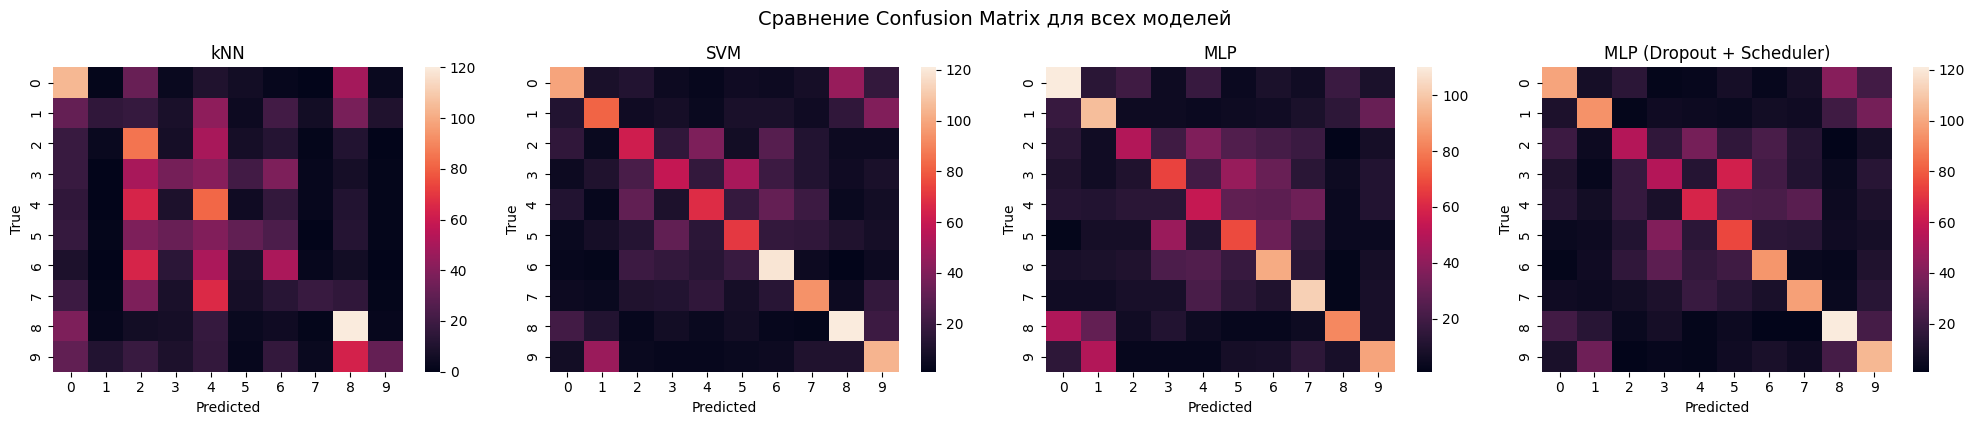

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Свод метрик по моделям
metrics_summary = {
    "Model": ["Random", "kNN", "SVM", "MLP", "MLP upgraded"],
    "Accuracy": [acc_random, acc_knn, acc_svm, acc_mlp, acc_mlp_upgraded],
    "Recall (macro)": [recall_random, recall_knn, recall_svm, recall_mlp, recall_mlp_upgraded],
    "Precision (macro)": [precision_random, precision_knn, precision_svm, precision_mlp, precision_mlp_upgraded],
    "F1-score (macro)": [f1_random, f1_knn, f1_svm, f1_mlp, f1_mlp_upgraded],
    "ROC-AUC (macro, OVR)": [roc_auc_random, roc_auc_knn, roc_auc_svm, roc_auc_mlp, roc_auc_mlp_upgraded],
    "Training Time (s)": [train_time_random, train_time_knn, train_time_svm, train_time_mlp, train_time_mlp_upgraded]
}

# Создаём DataFrame и округляем до 3 знаков
df_metrics = pd.DataFrame(metrics_summary)
df_metrics_rounded = df_metrics.copy()
df_metrics_rounded.iloc[:, 1:] = df_metrics_rounded.iloc[:, 1:].round(3)

# Выводим таблицу
print("\nСравнительная таблица метрик моделей (округлено):")
print(df_metrics_rounded)
display(df_metrics_rounded)

# Отображаем все confusion matrices вместе
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

sns.heatmap(cm_knn, ax=axes[0], annot=False, fmt='d')
axes[0].set_title('kNN')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_svm, ax=axes[1], annot=False, fmt='d')
axes[1].set_title('SVM')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(cm_mlp, ax=axes[2], annot=False, fmt='d')
axes[2].set_title('MLP')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

sns.heatmap(cm_mlp_upgraded, ax=axes[3], annot=False, fmt='d')
axes[3].set_title('MLP (Dropout + Scheduler)')
axes[3].set_xlabel('Predicted')
axes[3].set_ylabel('True')

plt.tight_layout()
plt.suptitle("Сравнение Confusion Matrix для всех моделей", fontsize=14, y=1.05)
plt.show()


## Итоговое сравнение результатов всех моделей:



### Сравнительный анализ таблицы с метриками:
- Лучший результат по метрикам - у SVM (accuracy и F1 = ~ 0.44).
- Лучшее соотношение качество / скорость - у MLP (с Dropout и Scheduler).
- Наихудшие показатели у kNN, как по метрикам, так и по устойчивости к переобучению.

### Confusion Matrix показывает:
- Все модели чаще путают классы животных (3, 4, 5, 6) - особенно у kNN.
- У MLP (с улучшениями) матрица ближе к диагональной - лучшая обобщающая способность.
- SVM тоже даёт хорошую структуру ошибок, особенно по технике (0, 1, 8, 9).

## Преимущества и недостатки каждого подхода

### kNN
Преимущества:
- Простая реализация.
- Мгновенное обучение.

Недостатки:
- Низкая точность (Accuracy 28.6%).
- Очень чувствителен к размерности.

### SVM
Преимущества:
- Лучшая точность и F1-score среди всех моделей.
- Хорошо справляется с небольшими выборками.

Недостатки:
- Очень очень долгая треннировка (почти 800 секунд).
- Требует тщательной настройки гиперпараметров (C, gamma) что занимает ещё больше времени.
- Плохо масштабируется на большие датасеты.

### MLP
Преимущества:
- Обучение в десятки раз быстрее, чем у SVM.
- Учитывает сложные нелинейные зависимости.
- Хорошая скорость.

Недостатки:
- Легко переобучается без регуляризации.
- Не чувствует пространственную структуру изображений.
- Чуть хуже по метрикам, чем улучшенная версия и SVM.

### MLP (с Dropout и Scheduler)
Преимущества:
- Наиболее сбалансированная модель - метрики близки к SVM, обучение быстрое.
- Dropout борется с переобучением, Scheduler улучшает сходимость.
- Идеальный компромисс между качеством, скоростью и стабильностью.

Недостатки:
- Всё ещё не использует пространственные зависимости (как CNN).

## Возможные улучшения моделей

### kNN / SVM:
- Извлекать признаки с помощью нейросетей (feature extraction), например, использовать CNN без обучения для генерации эмбеддингов.
- Применить PCA или t-SNE для уменьшения размерности перед подачей в kNN/SVM.
- Улучшить предобработку изображений, например применить аугментации, масштабирование, гистограммы.
- Лучше подобрать гиперпараметры через GridSearch или RandomizedSearch.

### MLP и MLP_upgraded:
- Заменить архитектуру на свёрточную нейросеть которая умеет эффективно выделять локальные признаки.
- Добавить Batch Normalization и Weight Decay.
- Использовать аугментации изображений (повороты, кропы, флип) для увеличения обобщающей способности.
- Расширить модель, добавив больше слоёв, или попробовав другие функции активации (LeakyReLU, GELU).
